# I. Data preparation and Recurrent Neural Netowork Modeling

In this document I shall use an RNN model to predicte the number of bikes rented. 

1. Data preparation
2. Model Creation
3. RNN implementation
4. Model testing


In [1]:
# import libraries
import os 
import csv
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
%matplotlib inline
%matplotlib inline

## 1. Data preparation

In this part, we shall import and merge the documents we have for training with its label.

### 1.1 Import datasets, remove duplicates and check for nulls

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
#quick visualization
rides.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [4]:
#see columns
rides.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [5]:
# See how many duplicates per instant I have on training data 
print(rides.shape)
print (rides.instant.unique().shape)

(17379, 17)
(17379,)


In [6]:
#See if I have any null
missing_values_check = rides.isnull().sum()
print(missing_values_check)

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


### Checking out the data
This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the cnt column.


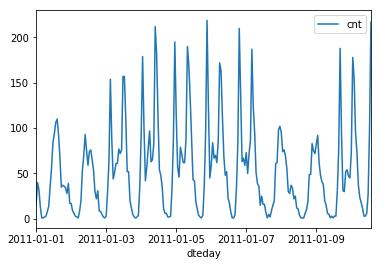

In [7]:
rides[:24*10].plot(x='dteday', y='cnt')

## 2. Feature Engineering

In [8]:
# see data types
rides.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [9]:
#Convert dteday column into correct format
rides['dteday'] = pd.to_datetime(rides['dteday'])

Then I look at the values per each category of the categorical variables. See there's none with few values

In [10]:
#view number of values for each potential dummy variable
print(rides.season.value_counts())

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64


In [11]:
print(rides.yr.value_counts())

1    8734
0    8645
Name: yr, dtype: int64


In [12]:
print(rides.mnth.value_counts())

7     1488
5     1488
12    1483
8     1475
3     1473
10    1451
6     1440
11    1437
9     1437
4     1437
1     1429
2     1341
Name: mnth, dtype: int64


In [13]:
print(rides.hr.value_counts())

16    730
17    730
15    729
13    729
14    729
22    728
18    728
19    728
20    728
21    728
23    728
12    728
7     727
8     727
9     727
10    727
11    727
0     726
6     725
1     724
5     717
2     715
4     697
3     697
Name: hr, dtype: int64


In [14]:
print(rides.holiday.value_counts())

0    16879
1      500
Name: holiday, dtype: int64


In [15]:
print(rides.weekday.value_counts())


6    2512
0    2502
5    2487
1    2479
3    2475
4    2471
2    2453
Name: weekday, dtype: int64


In [16]:
print(rides.workingday.value_counts())


1    11865
0     5514
Name: workingday, dtype: int64


In [17]:
print(rides.weathersit.value_counts())


1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64


In [59]:
print(rides.casual.value_counts())

0      1581
1      1082
2       798
3       697
4       561
5       509
6       448
7       405
8       377
9       348
10      317
11      315
12      299
13      258
14      233
15      225
17      219
16      218
18      212
19      206
27      193
20      189
21      173
31      164
25      158
33      155
24      155
22      152
28      152
23      151
       ... 
282       1
302       1
350       1
239       1
271       1
298       1
280       1
234       1
289       1
355       1
210       1
292       1
356       1
261       1
357       1
278       1
294       1
321       1
326       1
361       1
231       1
241       1
335       1
311       1
327       1
290       1
312       1
281       1
297       1
367       1
Name: casual, Length: 322, dtype: int64


In [19]:
print(rides.registered.value_counts())

4      307
3      294
5      287
6      266
2      245
1      201
7      200
8      190
9      178
11     140
10     133
19     106
22     105
14     101
15      95
20      95
13      93
16      92
23      90
12      90
17      85
24      83
26      83
21      81
18      80
25      77
95      75
30      75
28      73
29      71
      ... 
770      1
706      1
690      1
658      1
626      1
610      1
833      1
689      1
773      1
789      1
885      1
566      1
552      1
520      1
871      1
839      1
807      1
783      1
727      1
695      1
631      1
583      1
535      1
886      1
838      1
822      1
806      1
790      1
614      1
791      1
Name: registered, Length: 776, dtype: int64


In [20]:
##  Save data for visualizations
### 6. Save model for predictions
rides.to_csv("dfforvisualizations.csv", index=False)

### 2.1 Create dummy variables


In [21]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
data.shape

(17379, 59)

In [23]:
data.columns

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

## 3. Scaling Data

In [24]:
# we scale the quantitiative features
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [25]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
##  Save data for modeling
data.to_csv("dfformodeling.csv", index=False)

## 4. Model creation

### 4.1 Split data into training, testing and validation sets 

In [27]:
#Drop colinear columns
data=data.drop(['season_1','weathersit_1','mnth_1','hr_0','season_3','weekday_6','season_4','season_2'], axis=1)

In [28]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [29]:
#Now split training data into training and validation
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 4.2 Check for collinearity 
If there is any column presenting collinearity, it will be noted and dropped on at the beggining of part 4.1. Running the code below I shall find out the columns to be dropped. When no collinear columns appear, I can continue. 

In [30]:
# Check for collinearity
import numpy as np
import pandas as pd
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(features, thresh=5.0):
    variables = [features.columns[i] for i in range(features.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(features[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + features[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return features[[i for i in variables]]

X = features # Selecting your data

features = calculate_vif_(features,5) # Actually running the function

50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.4s finished


Remaining variables:
[['yr', 'holiday', 'temp', 'hum', 'windspeed', 'casual', 'registered', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5']]


## 5. Build and train a Neural Network

In [31]:
# import neural network from separate file
from neural_network import NeuralNetwork

In [32]:
# Set metric
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [33]:
# Test the correctness of the network implementation
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.014s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [43]:
# Run the Neural Network  model
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from neural_network import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.1% ... Training loss: 158.4 ... Validation loss: 164.8

c:\users\florence\anaconda333\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 100.0% ... Training loss: 0.052 ... Validation loss: 0.105

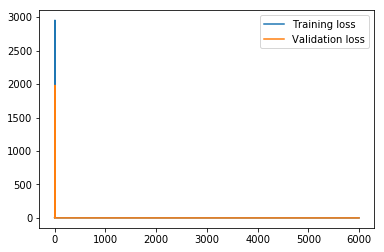

In [44]:
# Check the losses
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 6. Test the correctness of predictions

c:\users\florence\anaconda333\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


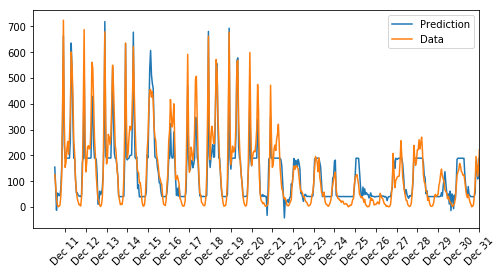

In [45]:
# Check out the predictions, see how well the netowrk is modeling data
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

Looking at chart above, we can be confident that the model will help us predict accurately the number of bikes that will be rent.
